In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset, test_dataset_visob, TestSampler2, test_dataset_2, test_dataset
from twrap.transform import ToZNorm

from twrap.utils import genROC

from torch.utils.data import Dataset

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob

from skimage import transform as T

from sklearn.metrics import roc_curve

import bcolz

from time import time

In [51]:
from torchvision.transforms import functional
from PIL import Image, ImageFilter

In [58]:
def noise_I(I, s):
    I = np.float32(I)/255.0
    I = I + np.random.normal(0.0, s/255, I.shape)
    I = np.clip(I, 0, 1)
    I = np.uint8(I * 255.0)
    return Image.fromarray(I)

In [16]:
weights_dir = '/media/narsi/LargeData/SP2019/ocularnetv2.1/EX01/weights'

model_instance_name = 'MODEL2_ATTEN1_SPH_COMB_C128_SALL_ROT20_SCALE80-100_BLUR0-1.5_COLORJIT'#

model = MODEL2(400, classify = False, attention = True)
check_point_file = weights_dir+ os.sep +model_instance_name + '/model_best.pth.tar'
checkpoint = torch.load(check_point_file, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()
print('.')

.


In [18]:
transform=transforms.Compose([
    transforms.Resize(144),
    transforms.CenterCrop(128)
    ])

transform2=transforms.Compose([
    transforms.Grayscale(),
    ToZNorm()
    ])

In [7]:
I = Image.open('/media/narsi/fast_drive/CCRops/visob/imgs/EC_VISIT_1/IPHONE/office/S1/1172_l_5.png')

In [8]:
I1 = transform(I)

In [23]:
I11 = transform2(I1)
input_var = tensor_to_torch_var(I11.unsqueeze(0), True)
F11, _, A11, _ = model.getLocalFeat(input_var)

In [65]:
for b in list(np.arange(0.1, 2.4, 0.2)):
    for n in list(np.arange(2.0, 25.0, 2.0)):
        I12 = transform2(noise_I(I1.filter(ImageFilter.GaussianBlur(b)), n))
        input_var = tensor_to_torch_var(I12.unsqueeze(0), True)
        F12, _, A12, _ = model.getLocalFeat(input_var)

        score = nn.functional.cosine_similarity(F11, F12).mean().item()

        print('Blur ' + str(b) + '  Noise ' + str(n) + ':: ' + "{0:0.2f}".format(score))

Blur 0.1  Noise 2.0:: 0.99
Blur 0.1  Noise 4.0:: 0.98
Blur 0.1  Noise 6.0:: 0.96
Blur 0.1  Noise 8.0:: 0.94
Blur 0.1  Noise 10.0:: 0.90
Blur 0.1  Noise 12.0:: 0.88
Blur 0.1  Noise 14.0:: 0.84
Blur 0.1  Noise 16.0:: 0.82
Blur 0.1  Noise 18.0:: 0.79
Blur 0.1  Noise 20.0:: 0.72
Blur 0.1  Noise 22.0:: 0.69
Blur 0.1  Noise 24.0:: 0.66
Blur 0.30000000000000004  Noise 2.0:: 0.99
Blur 0.30000000000000004  Noise 4.0:: 0.98
Blur 0.30000000000000004  Noise 6.0:: 0.96
Blur 0.30000000000000004  Noise 8.0:: 0.93
Blur 0.30000000000000004  Noise 10.0:: 0.90
Blur 0.30000000000000004  Noise 12.0:: 0.87
Blur 0.30000000000000004  Noise 14.0:: 0.85
Blur 0.30000000000000004  Noise 16.0:: 0.79
Blur 0.30000000000000004  Noise 18.0:: 0.76
Blur 0.30000000000000004  Noise 20.0:: 0.76
Blur 0.30000000000000004  Noise 22.0:: 0.71
Blur 0.30000000000000004  Noise 24.0:: 0.66
Blur 0.5000000000000001  Noise 2.0:: 0.99
Blur 0.5000000000000001  Noise 4.0:: 0.97
Blur 0.5000000000000001  Noise 6.0:: 0.95
Blur 0.50000000000

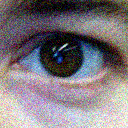

In [66]:
noise_I(I1, 25)